In [10]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

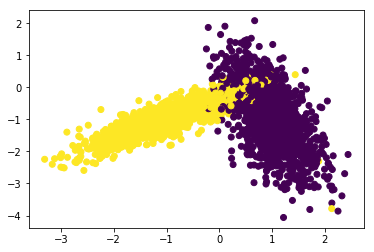

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [18]:
from sklearn.metrics import accuracy_score

def RandomSearchCV(x_train, y_train, clf, params, folds):
    train_scores = []
    cv_scores  = []    
    for k in tqdm(params['n_neighbors']):
        train_scores_folds = []
        cv_scores_folds  = []
        for j in range(folds):
            cv_indices = list(range(j*len(x_train)//folds, (j+1)*len(x_train)//folds))
            train_indices  = list( set(range(len(x_train))) - set(cv_indices) )

            # selecting the data points based on the train_indices and test_indices
            X_train = x_train[train_indices]
            Y_train = y_train[train_indices]
            X_cv  = x_train[cv_indices]
            Y_cv  = y_train[cv_indices]

            clf.n_neighbors = k
            clf.fit(X_train, Y_train)

            Y_predicted = clf.predict(X_cv)
            cv_scores_folds.append(accuracy_score(Y_cv, Y_predicted))

            Y_predicted = clf.predict(X_train)
            train_scores_folds.append(accuracy_score(Y_train, Y_predicted))
            
        train_scores.append(np.mean(train_scores_folds))
        cv_scores.append(np.mean(cv_scores_folds))
    return train_scores, cv_scores
# ----------------------------------------------------------------------------------------------------
import random
def random_numbers(param_range, m):
    if type(m)!=int:
        print('m should be an integer')
    elif m > (param_range[1]-param_range[0])/2:
        print('m value should be <= {} to genereate odd numbers in the range {}'.format(int((param_range[1]-param_range[0])/2), param_range))
    else:
        return sorted(random.sample([i for i in range(param_range[0], param_range[1]) if i%2==1], m))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.42it/s]


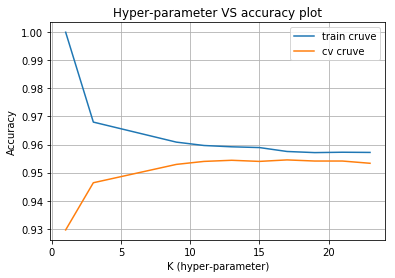

In [19]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()

param_range = (1, 25)
# let say I want to create 10 unique random numbers (preferebly odd numbers) in the range (1, 25)
m = 10 # m is the number of random numbers : 
params = {'n_neighbors':random_numbers(param_range, m)}
folds = 3

train_scores, cv_scores = RandomSearchCV(X_train, y_train, clf_knn, params, folds)
 
plt.plot(params['n_neighbors'], train_scores, label='train cruve')
plt.plot(params['n_neighbors'], cv_scores, label='cv cruve')
plt.xlabel('K (hyper-parameter)')
plt.ylabel('Accuracy')
plt.title('Hyper-parameter VS accuracy plot')
plt.grid()
plt.legend()
plt.show()

#### From the above figure, it is clear that at K=17, out model is giving maximum CV accuracy that is almost 95%

In [16]:
def plot_decision_boundary(X1, X2, y, clf):
    # ---------Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid( np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02) )
    Z = clf.predict(np.c_[ xx.ravel(), yy.ravel() ])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

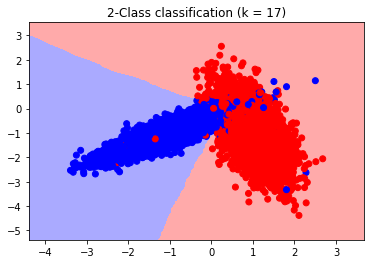

In [17]:
from matplotlib.colors import ListedColormap

neigh = KNeighborsClassifier(n_neighbors = 17).fit(X_train, y_train)

plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)